## Setup

In [1]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [2]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


2025-08-05 03:34:11.673 | INFO     |  Running on cpu


In [3]:
task = 'BlockTablePink'
path = data_root / task / 'demos'

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

2025-08-05 03:34:19.036 | INFO     |  Loading dataset(s): 
2025-08-05 03:34:19.038 | INFO     |    Initializing datasete using /home/jangruhnert/Projects/TapasCalvin/data/BlockTablePink/demos/metadata.json
2025-08-05 03:34:19.043 | INFO     |    Extracted gt object labels [0, 1, 2, 3, 4, 5, 6]
2025-08-05 03:34:19.043 | INFO     |    Extracted tsdf object labels []
2025-08-05 03:34:19.044 | INFO     |    Done! Data contains 5 trajectories.
SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=

In [4]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [5]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([142, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([142]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([142, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([142, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([142, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([142, 3, 256, 256]), device=cpu, dt

In [6]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,
    add_gripper_action=True,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=10,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=1,
    min_end_distance=20,
    velocity_threshold=0.002,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [7]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-05 03:34:34.795 | INFO     |  Fitting AutoTPGMM
2025-08-05 03:34:34.796 | INFO     |  Performing fitting actions: [INIT]
2025-08-05 03:34:34.797 | INFO     |  Segmenting trajectories


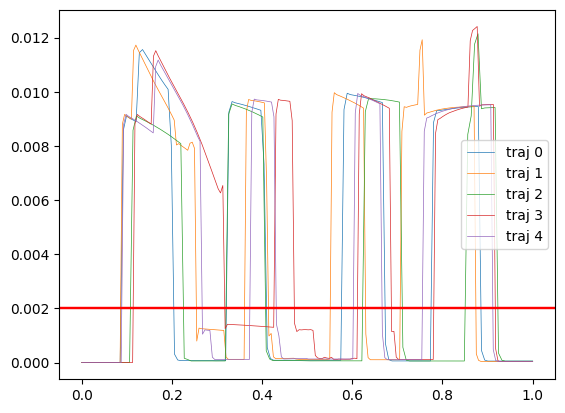

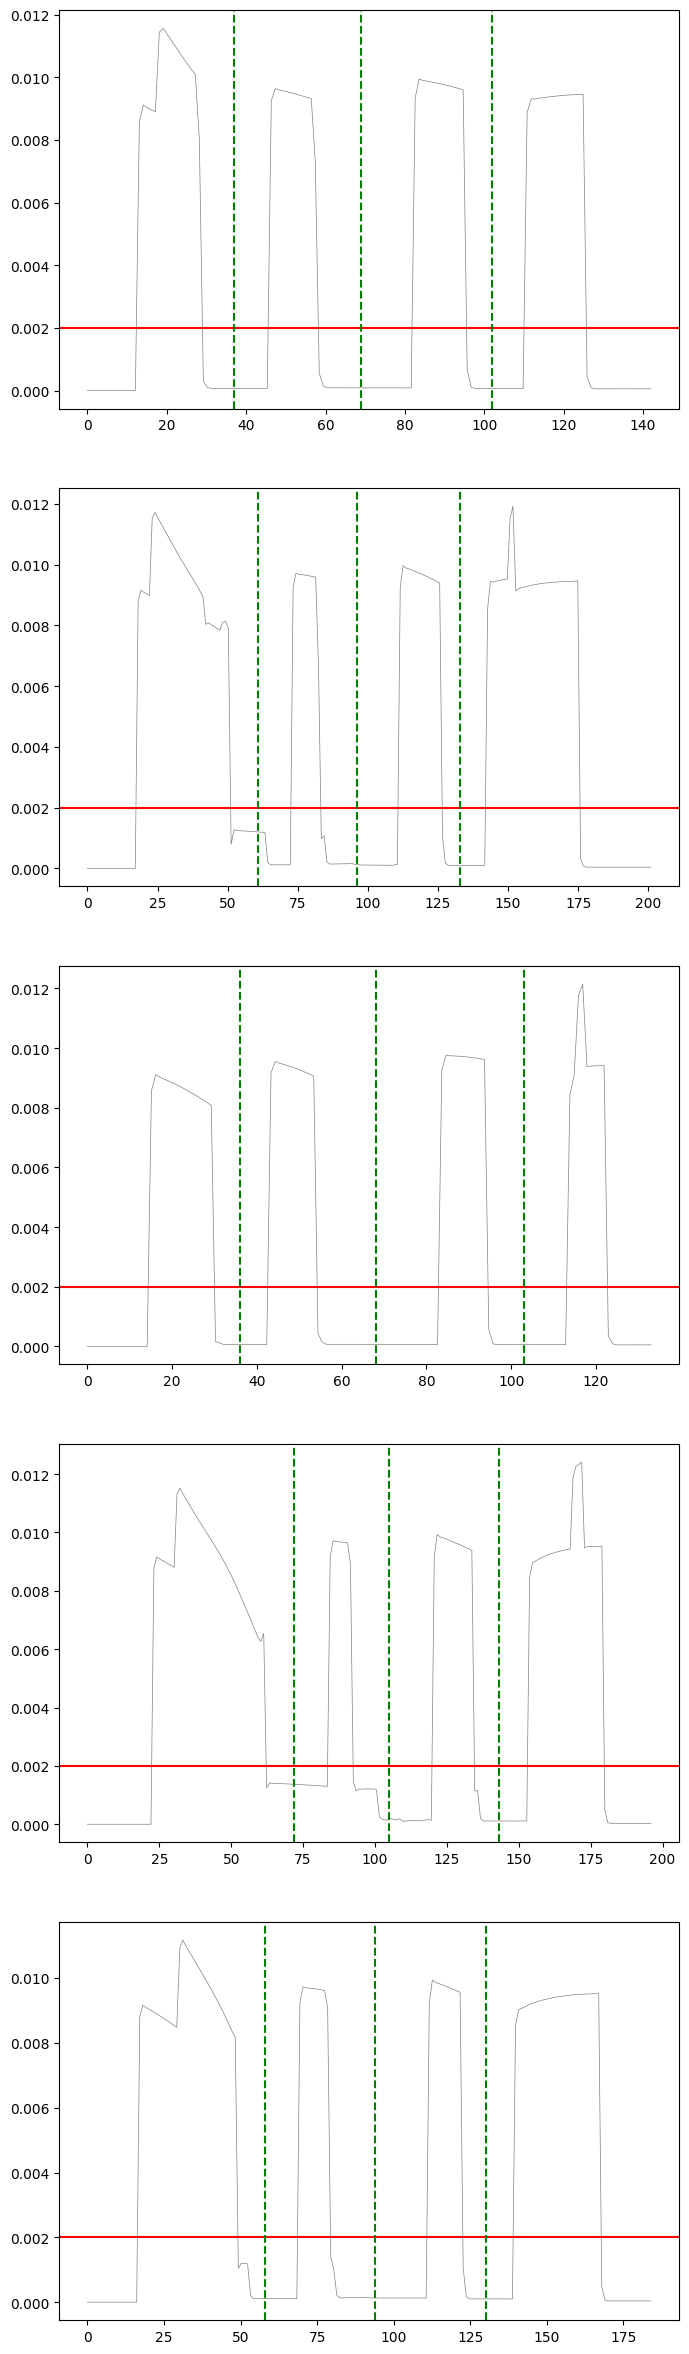

2025-08-05 03:34:36.556 | INFO     |  Creating segement of demos.
2025-08-05 03:34:36.572 | INFO     |  Subsampling to length 61 using strategy mean-length.
2025-08-05 03:34:36.575 | INFO     |  Creating segement of demos.
2025-08-05 03:34:36.591 | INFO     |  Subsampling to length 42 using strategy mean-length.
2025-08-05 03:34:36.594 | INFO     |  Creating segement of demos.
2025-08-05 03:34:36.604 | INFO     |  Subsampling to length 44 using strategy mean-length.
2025-08-05 03:34:36.607 | INFO     |  Creating segement of demos.
2025-08-05 03:34:36.618 | INFO     |  Subsampling to length 58 using strategy mean-length.
2025-08-05 03:34:36.621 | INFO     |  ... created 4 segments
2025-08-05 03:34:36.621 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:34:36.622 | INFO     |    Creating partial frame view of demos.
2025-08-05 03:34:36.645 | INFO     |    Manifold: TIME x R3 x QUAT x R1
2025-08-05 03:34:36.645 | INFO     |    Changing number of components to 2
2025-08-05 03:34:

Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:36.992 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:34:36.993 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:37.324 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:34:37.325 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:37.609 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:34:37.610 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:37.922 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:34:37.922 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:38.218 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:34:38.219 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:38.615 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:34:38.616 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:38.878 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:34:38.879 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:39.139 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:34:39.140 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:39.411 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:34:39.411 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:39.716 | INFO     |  ee_init    score (rel):     -0 (1.000)
2025-08-05 03:34:39.716 | INFO     |  obj000     score (rel):     -0 (1.000)
2025-08-05 03:34:39.716 | INFO     |  obj001     score (rel):     -0 (1.000)
2025-08-05 03:34:39.717 | INFO     |  obj002     score (rel):     -0 (1.000)
2025-08-05 03:34:39.717 | INFO     |  obj003     score (rel):     -0 (1.000)
2025-08-05 03:34:39.717 | INFO     |  obj004     score (rel):     -0 (1.000)
2025-08-05 03:34:39.717 | INFO     |  obj005     score (rel):     -0 (1.000)
2025-08-05 03:34:39.717 | INFO     |  obj006     score (rel):     -0 (0.019)
2025-08-05 03:34:39.717 | INFO     |  obj007     score (rel):     -0 (0.016)
2025-08-05 03:34:39.717 | INFO     |  obj008     score (rel):     -0 (0.976)
2025-08-05 03:34:39.719 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:34:39.792 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:34:39.792 | INFO     |    Creating partial frame view of demos.
2025-08

Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:39.956 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:34:39.957 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:40.152 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:34:40.153 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:40.344 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:34:40.345 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:40.524 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:34:40.525 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:40.731 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:34:40.732 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:40.947 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:34:40.948 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:41.139 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:34:41.140 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:41.329 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:34:41.330 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:41.512 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:34:41.513 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:41.814 | INFO     |  ee_init    score (rel):     -0 (0.041)
2025-08-05 03:34:41.817 | INFO     |  obj000     score (rel):     -0 (0.041)
2025-08-05 03:34:41.818 | INFO     |  obj001     score (rel):     -0 (0.041)
2025-08-05 03:34:41.819 | INFO     |  obj002     score (rel):     -0 (0.041)
2025-08-05 03:34:41.819 | INFO     |  obj003     score (rel):     -0 (0.041)
2025-08-05 03:34:41.819 | INFO     |  obj004     score (rel):     -0 (0.041)
2025-08-05 03:34:41.819 | INFO     |  obj005     score (rel):     -0 (0.041)
2025-08-05 03:34:41.820 | INFO     |  obj006     score (rel):     -0 (0.001)
2025-08-05 03:34:41.820 | INFO     |  obj007     score (rel):     -0 (0.001)
2025-08-05 03:34:41.820 | INFO     |  obj008     score (rel):     -1 (1.000)
2025-08-05 03:34:41.821 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:34:41.825 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:34:41.826 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:42.121 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:34:42.122 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:42.324 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:34:42.325 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:42.531 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:34:42.532 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:42.707 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:34:42.708 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:42.943 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:34:42.944 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:43.163 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:34:43.164 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:43.393 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:34:43.394 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:43.620 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:34:43.621 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:43.807 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:34:43.808 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:34:44.026 | INFO     |  ee_init    score (rel):     -0 (0.058)
2025-08-05 03:34:44.028 | INFO     |  obj000     score (rel):     -0 (0.058)
2025-08-05 03:34:44.029 | INFO     |  obj001     score (rel):     -0 (0.058)
2025-08-05 03:34:44.029 | INFO     |  obj002     score (rel):     -0 (0.058)
2025-08-05 03:34:44.029 | INFO     |  obj003     score (rel):     -0 (0.058)
2025-08-05 03:34:44.029 | INFO     |  obj004     score (rel):     -0 (0.058)
2025-08-05 03:34:44.029 | INFO     |  obj005     score (rel):     -0 (0.058)
2025-08-05 03:34:44.029 | INFO     |  obj006     score (rel):     -0 (0.002)
2025-08-05 03:34:44.030 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:34:44.033 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:34:44.033 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:44.344 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:34:44.345 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:44.584 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:34:44.584 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:44.986 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:34:44.987 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:45.424 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:34:45.424 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:45.769 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:34:45.769 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:46.103 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:34:46.104 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:46.379 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:34:46.379 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:46.638 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:34:46.639 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:46.956 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:34:46.957 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/2 [00:00<?, ?it/s]

2025-08-05 03:34:47.265 | INFO     |  ee_init    score (rel):     -0 (0.214)
2025-08-05 03:34:47.266 | INFO     |  obj000     score (rel):     -0 (0.214)
2025-08-05 03:34:47.266 | INFO     |  obj001     score (rel):     -0 (0.214)
2025-08-05 03:34:47.266 | INFO     |  obj002     score (rel):     -0 (0.214)
2025-08-05 03:34:47.266 | INFO     |  obj003     score (rel):     -0 (0.214)
2025-08-05 03:34:47.266 | INFO     |  obj004     score (rel):     -0 (0.214)
2025-08-05 03:34:47.266 | INFO     |  obj005     score (rel):     -0 (0.214)
2025-08-05 03:34:47.266 | INFO     |  obj006     score (rel):     -0 (0.005)
2025-08-05 03:34:47.267 | INFO     |  obj007     score (rel):     -0 (0.003)
2025-08-05 03:34:47.268 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:34:47.275 | INFO     |  Segmented trajs into 4 segments
2025-08-05 03:34:47.319 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.142384 -0.142384 -

Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:34:47.396 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R1
2025-08-05 03:34:47.397 | INFO     |  Changing number of components to 3


Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

Time-based init:   0%|          | 0/3 [00:00<?, ?it/s]

((array([[1.01e+061, 1.01e+061, 9.76e+060, 9.11e+060, 8.21e+060, 7.15e+060,
          6.02e+060, 4.90e+060, 3.85e+060, 2.92e+060, 2.14e+060, 1.52e+060,
          1.04e+060, 6.86e+059, 4.38e+059, 2.70e+059, 1.61e+059, 9.28e+058,
          2.55e+058, 1.37e+058, 1.03e+057, 2.27e+055, 1.10e+055, 7.06e+052,
          1.40e+050, 1.28e+047, 1.87e+043, 7.61e+042, 1.82e+038, 8.05e+032,
          2.96e+032, 2.63e+026, 5.28e+019, 2.60e+012, 3.37e+004, 1.04e+004,
          3.69e-005, 3.88e-014, 1.08e-014, 3.92e-021, 6.78e-022, 2.08e-022,
          5.91e-023, 1.39e-023, 3.67e-024, 9.38e-025, 1.99e-025, 4.74e-026,
          1.09e-026, 2.08e-027, 3.85e-028, 6.86e-029, 1.18e-029, 1.96e-030,
          3.16e-031, 4.90e-032, 7.36e-033, 1.07e-033, 1.49e-034, 2.02e-035,
          2.64e-036, 8.15e+060, 8.15e+060, 7.87e+060, 7.35e+060, 6.62e+060,
          5.77e+060, 4.86e+060, 3.95e+060, 3.10e+060, 2.35e+060, 1.73e+060,
          1.22e+060, 8.36e+059, 5.53e+059, 3.53e+059, 2.18e+059, 1.30e+059,
          7.

In [8]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-05 03:34:50.718 | INFO     |  Did not specify time_based, deciding automatically.
2025-08-05 03:34:51.139 | WARNING  |  Skippig NaN Gaussians.


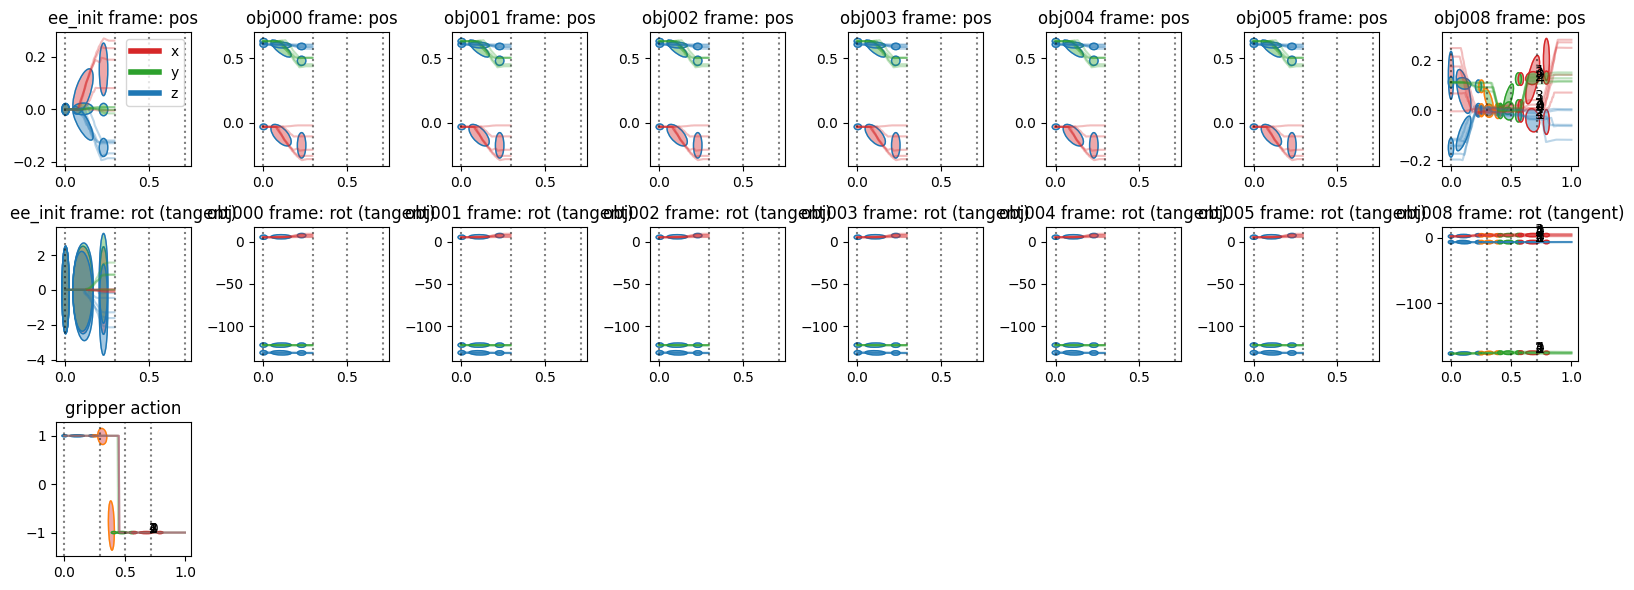

In [9]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [10]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-05 03:34:58.068 | INFO     |  Fitting AutoTPGMM
2025-08-05 03:34:58.069 | INFO     |  Performing fitting actions: [EM_HMM]


Fitting segments:   0%|          | 0/4 [00:00<?, ?it/s]

2025-08-05 03:34:58.090 | INFO     |  HMM EM ...
2025-08-05 03:34:58.120 | INFO     |  HMM transition matrix not defined, initializing to uniform


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

2025-08-05 03:34:58.372 | INFO     |  HMM init priors not defined, initializing to uniform
2025-08-05 03:35:07.154 | INFO     |  HMM EM converged


HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[4.48e-006, 3.80e-006, 2.84e-006, 1.78e-006, 8.95e-007, 3.48e-007,
          1.01e-007, 2.12e-008, 3.14e-009, 3.19e-010, 2.18e-011, 9.76e-013,
          2.81e-014, 5.09e-016, 5.68e-018, 3.83e-020, 1.53e-022, 3.57e-025,
          1.90e-028, 5.48e-032, 1.03e-036, 4.00e-043, 7.52e-050, 9.00e-059,
          2.28e-070, 5.19e-085, 1.75e-103, 2.30e-122, 7.61e-146, 1.21e-174,
          6.69e-204, 3.65e-239, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 5.91e-007, 3.23e-007, 1.55e-007, 6.38e-008, 2.21e-008,
          6.34e-009, 1.47e-009, 2.69e-010, 3.83e-011, 4.15e-012, 3.35e-013,
          1.98e-014, 8.33e-016, 2.47e-017, 5.03e-019, 6.90e-021, 6.24e-023,
          3.

2025-08-05 03:35:15.075 | INFO     |  Did not specify time_based, deciding automatically.


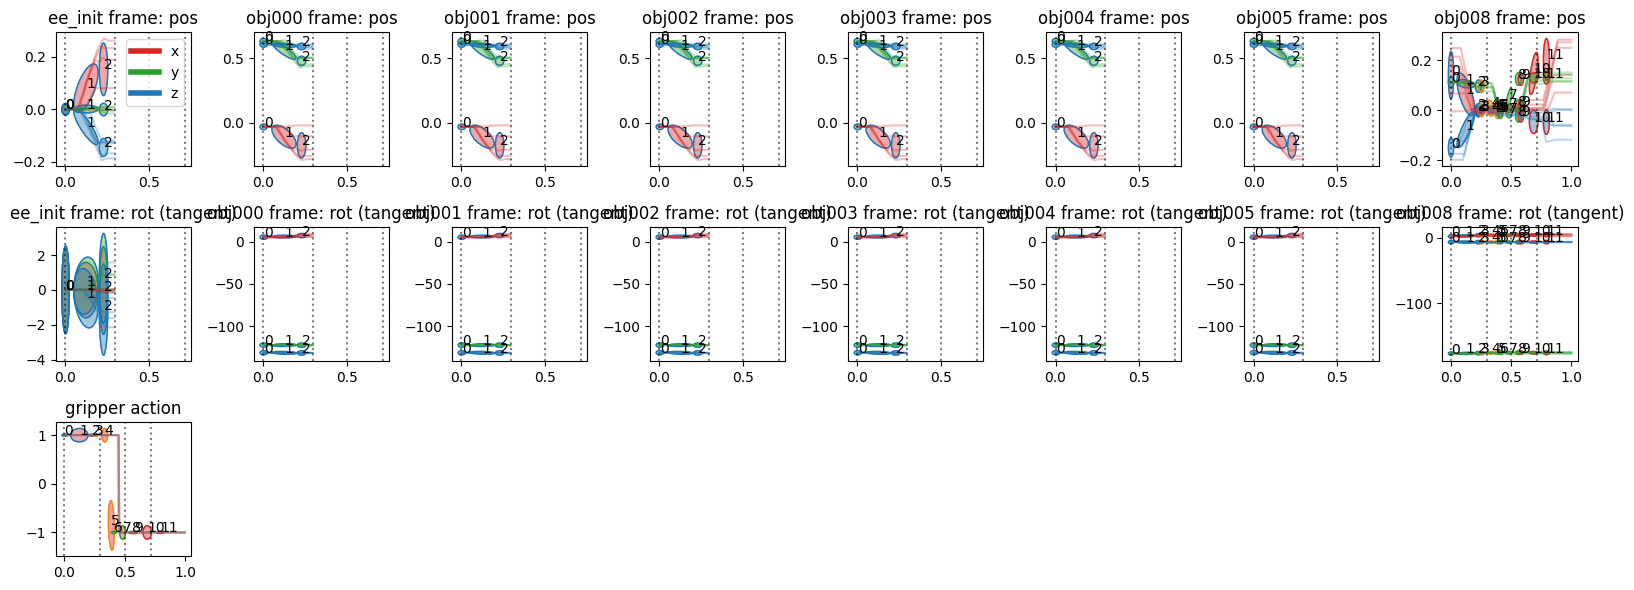

In [11]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

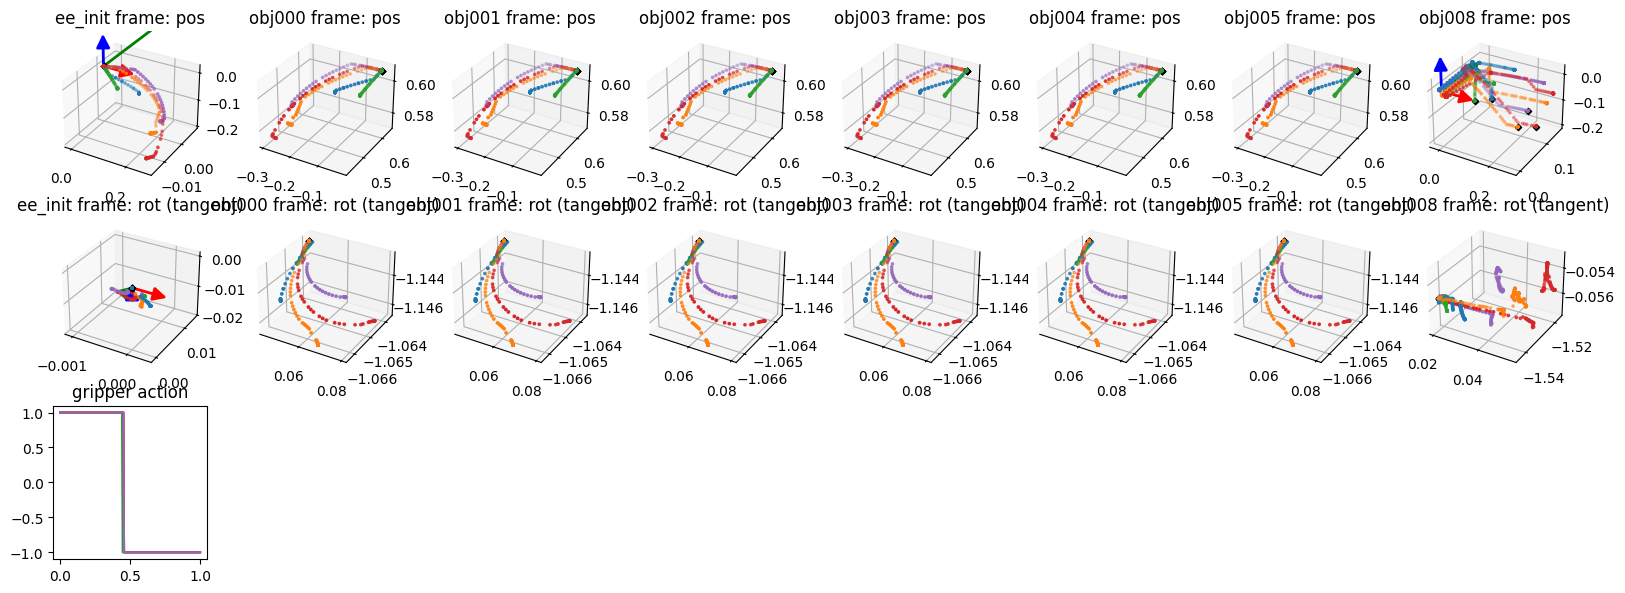

In [12]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

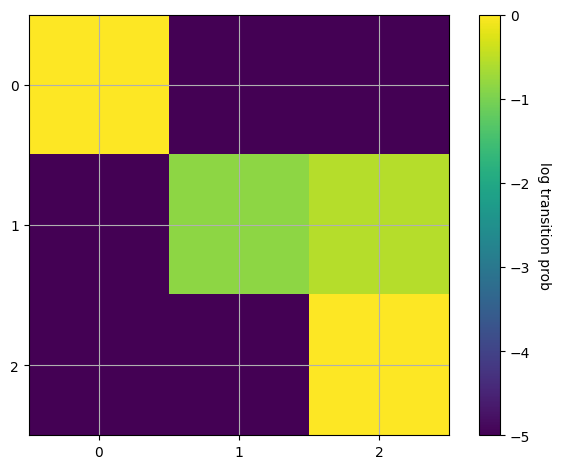

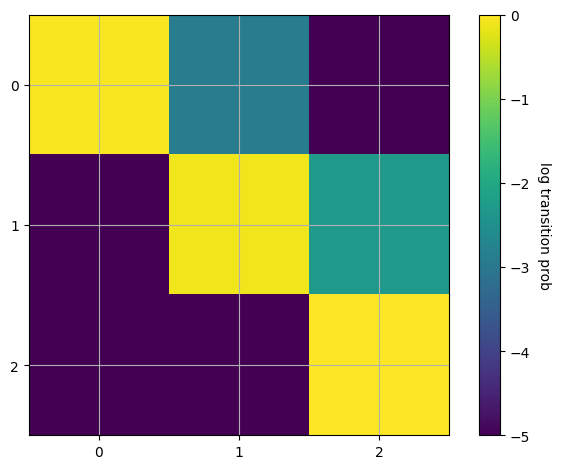

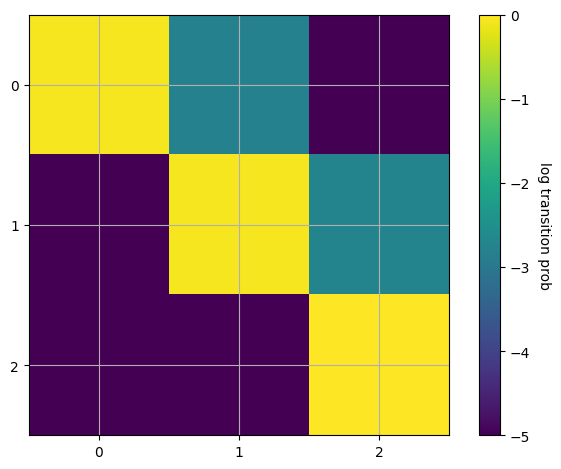

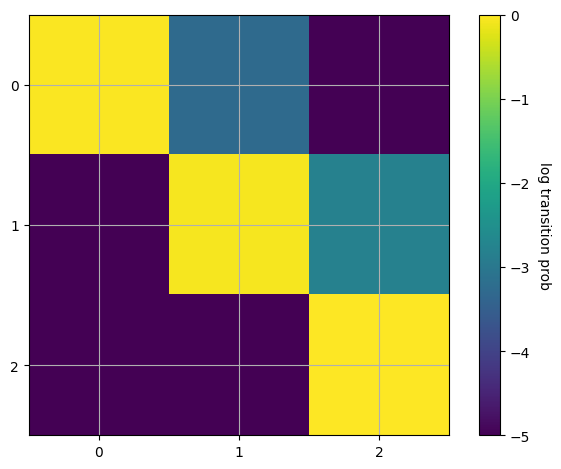

In [13]:
atpgmm.plot_hmm_transition_matrix()

In [14]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

2025-08-05 03:35:33.353 | INFO     |  Saving model:


In [15]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


2025-08-05 03:35:33.738 | INFO     |  Time-based reconstruction not specified. Auto selected True.
2025-08-05 03:35:33.885 | INFO     |  Caculated segment transition probabilities: (array([[1.]]), array([[1.]]), array([[1.]]))
2025-08-05 03:35:33.886 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:35:34.013 | INFO     |  Assuming zero frame velocity. Should be fixed.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:35:35.270 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:35:35.410 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:35:35.467 | INFO     |  Creating partial frame view of demos.


Transforming marginals:   0%|          | 0/5 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/5 [00:00<?, ?it/s]

2025-08-05 03:35:35.533 | WARNING  |  Setting init priors of later segments to zero.


GMR:   0%|          | 0/5 [00:00<?, ?it/s]

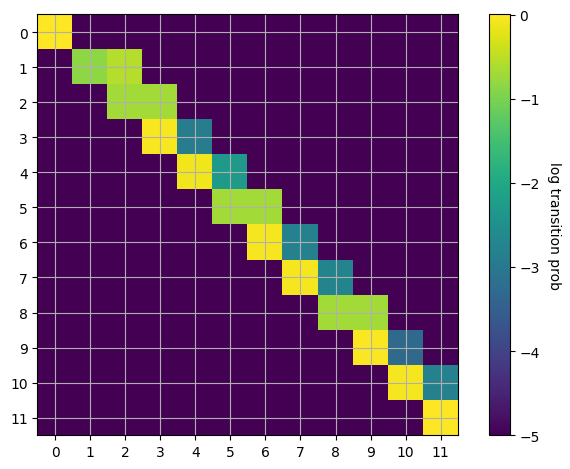

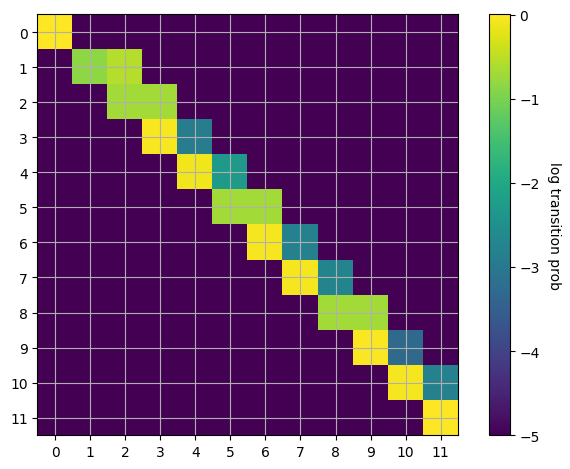

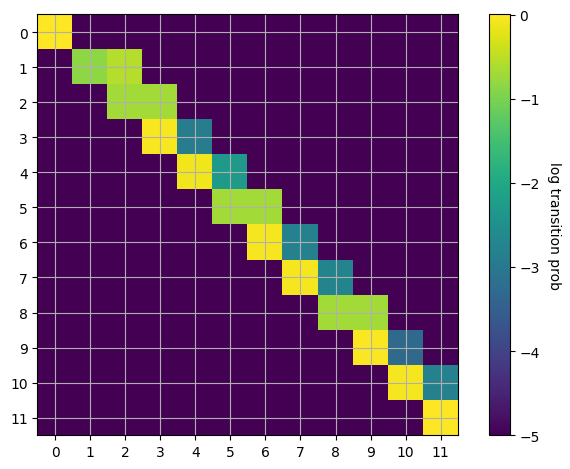

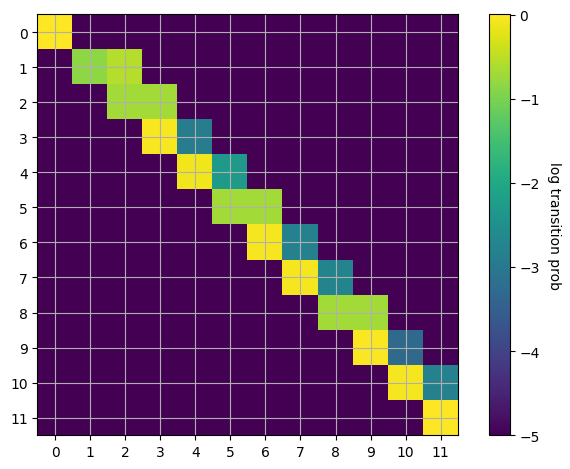

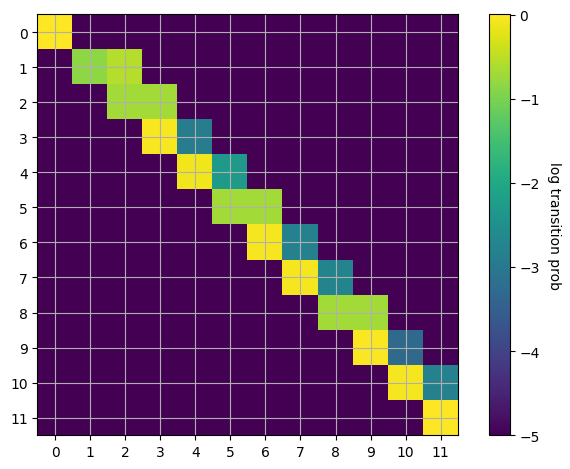

In [16]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-08-05 03:35:51.871 | INFO     |  Taking frame origins from demos.


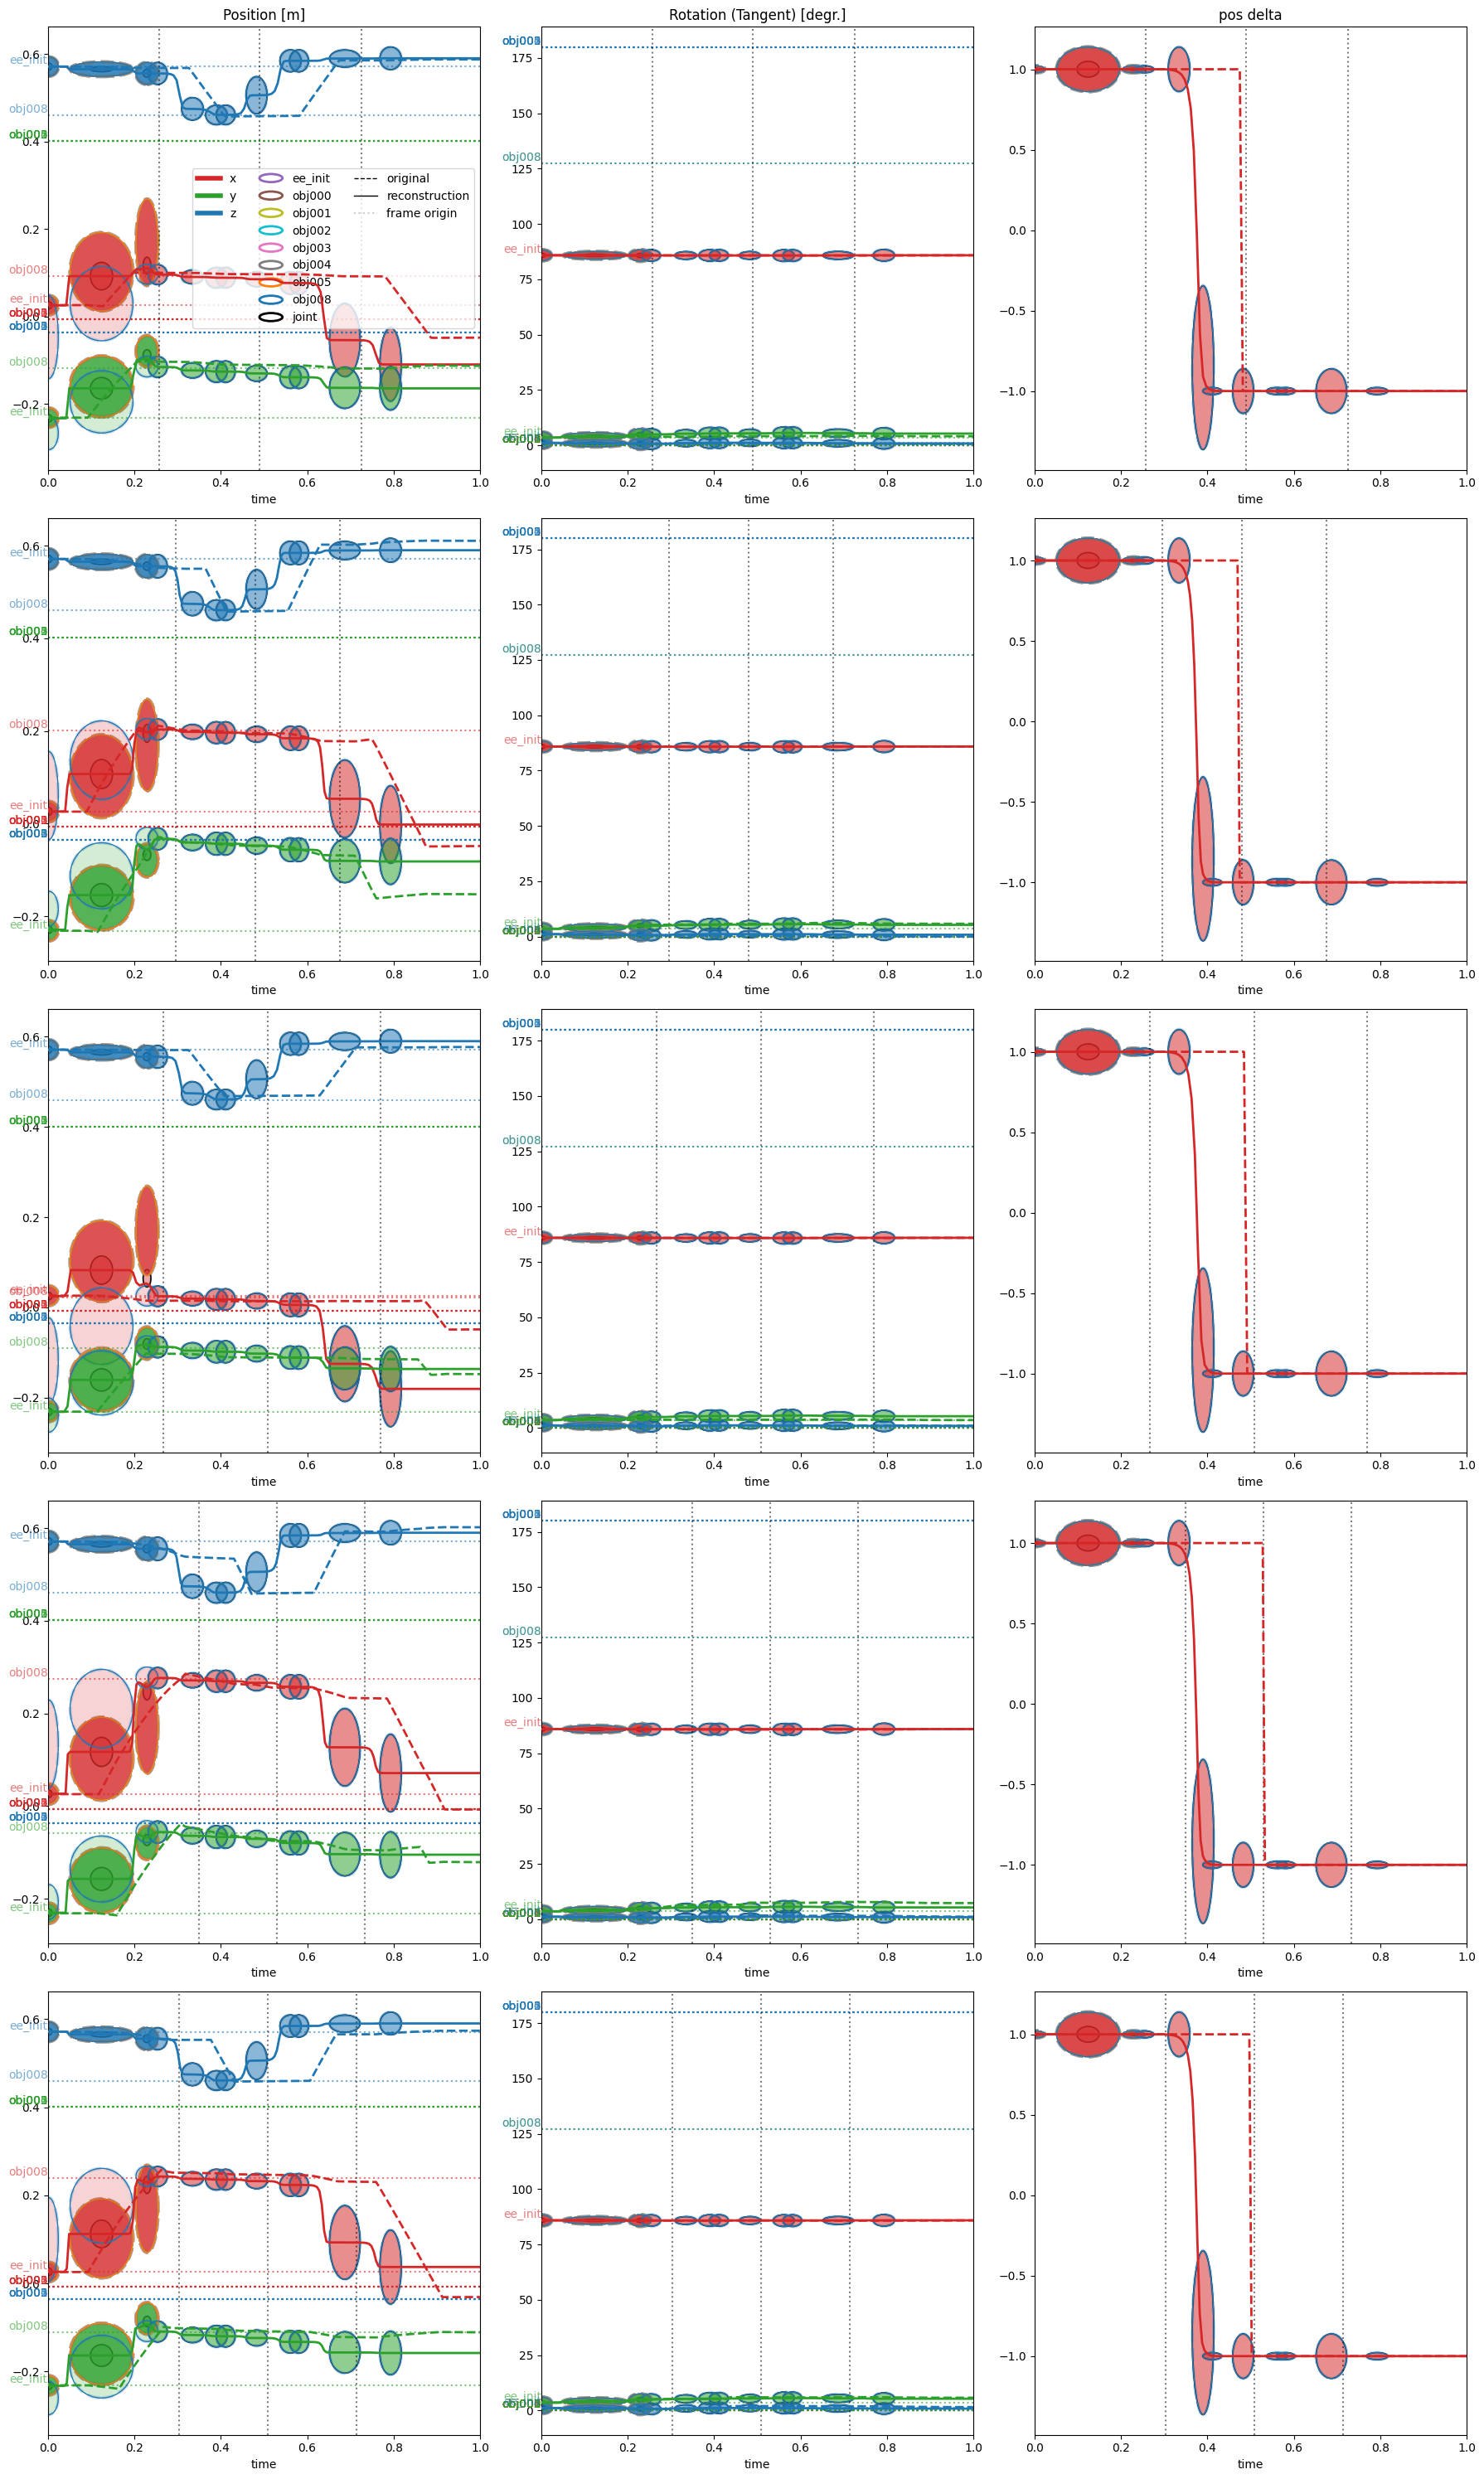

In [17]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)


IndexError: tuple index out of range

: 